## File for locate bruise
##### Tresholds, og alt det der

In [27]:
import numpy as np
import spectral as sp
import matplotlib.pyplot as plt
import cv2
from sklearn import svm

from functions import clip, PCAreduce, plotSpectrum, meanSpectrum, getImage, getRegion

SVC()

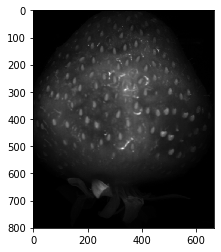

In [28]:
names = np.array(["before-hit", "0m","30m","1h" ,"3h","12h", "24h", "48h"])

strawberryCube = sp.open_image(getImage("12h"))
strawberryCubeBefore = sp.open_image(getImage("before-hit"))
N,M,Bands = strawberryCube.shape
strawberry = strawberryCube.read_subregion((4700,N), (0,666)) # strawberry ID 1 (750,M)
                                                            # strawberry ID 2 (0,666)

sp.imshow(strawberry[:,:,180])

X_train1 = getRegion(strawberryCube, 232, 5090, 19) # 
n,m,Bands = X_train1.shape
X_train1 = X_train1.reshape((n*m,Bands)) # just bruised data
y_train1 = np.ones(n*m)  # labels, 1 = bruised

X_train2 = getRegion(strawberryCube, 252, 4905, 19) # 
n,m,Bands = X_train2.shape
X_train2 = X_train2.reshape((n*m,Bands)) # just healthy data 
y_train2 = np.zeros(n*m)  # labels, 0 = healthy


X_train = np.zeros( (2 * y_train2.shape[0], Bands) )

X_train[:y_train2.shape[0]] = X_train1
X_train[y_train2.shape[0]:] = X_train2
y_train = np.zeros((y_train2.shape[0]*2))

y_train[:y_train.shape[0]//2] = y_train1
y_train[y_train.shape[0]//2:] = y_train2



svm = svm.SVC() 
svm.fit(X_train, y_train)




ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0, 255.0]
    G: [0.0, 255.0]
    B: [0.0, 255.0]

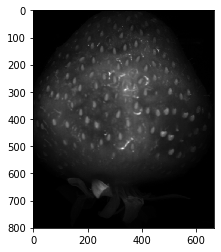

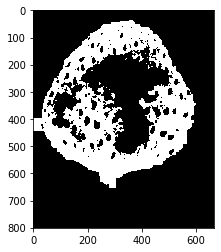

In [29]:
test = strawberry[:,:,180]
test8bit = (test*255).astype('uint8')
#th3 = cv2.adaptiveThreshold(test8bit,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,21,1)
tresh = cv2.threshold(test8bit,10,255, cv2.THRESH_BINARY)[1]
kernel = np.ones((7,7),np.uint8)
closing  = cv2.morphologyEx(tresh, cv2.MORPH_CLOSE, kernel, iterations=1)
erode = cv2.erode(closing,kernel, iterations =10)

#X_test = getRegion(strawberryCube, 320, 5040, 320)
X_test = strawberry

n,m,Bands = X_test.shape
X_test = X_test.reshape((n*m,Bands)) # just healthy data 



pred = svm.predict(X_test)
predimg = pred.reshape((n,m))

sp.imshow(strawberry[:,:,180])
sp.imshow(predimg*erode)

#sp.imshow(X_train)


In [ ]:
names = np.array(["before-hit", "0m","30m","1h" ,"3h","12h", "24h", "48h"])

strawberryCube = sp.open_image(getImage("12h"))
N,M,Bands = strawberryCube.shape
strawberry = strawberryCube.read_subregion((4700,N), (0,666)) # strawberry ID 1 (750,M)
                                                              # strawberry ID 2 (0,666)
#clip(strawberry,0,1)
sp.imshow(strawberry[:,:,180],figsize=(5,10))



test = strawberry[:,:,180]
test8bit = (test*255).astype('uint8')
#th3 = cv2.adaptiveThreshold(test8bit,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,21,1)
tresh = cv2.threshold(test8bit,10,255, cv2.THRESH_BINARY)[1]
kernel = np.ones((7,7),np.uint8)
closing  = cv2.morphologyEx(tresh, cv2.MORPH_CLOSE, kernel, iterations=1)
erode = cv2.erode(closing,kernel, iterations =10)

#mask = erode
kernel = np.ones((3,3),np.uint8)

imggrad =  (cv2.dilate(test,kernel) - cv2.erode(test,kernel)) #* mask

imggrad[imggrad < imggrad[300,210]] = 0
imggrad[imggrad >= imggrad[300,210]] = 1
eroded = cv2.dilate(cv2.erode(imggrad,kernel, iterations =5),kernel,iterations =2)

sp.imshow(eroded,figsize=(5,10))

imgNoSeeds = test*(1-eroded)

sp.imshow(imgNoSeeds,figsize=(5,10))


